In [6]:
import cv2
import mediapipe as mp
import pandas as pd
import os
import math

In [7]:
import cv2
import math
import pandas as pd
import os
import mediapipe as mp

# Variables globales para coordenadas y flags
x1, y1, x2, y2 = 0, 0, 0, 0
flag_click1, flag_click2 = False, False

def distancia_landmark(x1, y1, x2, y2):
    
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def click_distancia1(event, x, y, flags, params):
    """
    Callback para el primer punto de clic en el video.

    Args:
        event: Tipo de evento de mouse.
        x: Coordenada X del clic.
        y: Coordenada Y del clic.
        flags: Flags del evento de mouse.
        params: Parámetros adicionales.
    """
    global x1, y1, flag_click1
    if event == cv2.EVENT_LBUTTONDOWN:
        x1, y1 = x, y
        flag_click1 = True

def click_distancia2(event, x, y, flags, params):
    """
    Callback para el segundo punto de clic en el video.

    Args:
        event: Tipo de evento de mouse.
        x: Coordenada X del clic.
        y: Coordenada Y del clic.
        flags: Flags del evento de mouse.
        params: Parámetros adicionales.
    """
    global x2, y2, flag_click2
    if event == cv2.EVENT_LBUTTONDOWN:
        x2, y2 = x, y
        flag_click2 = True

def click_event(event, x, y, flags, params):
    """
    Callback para eventos de clic en el video.

    Args:
        event: Tipo de evento de mouse.
        x: Coordenada X del clic.
        y: Coordenada Y del clic.
        flags: Flags del evento de mouse.
        params: Parámetros adicionales.
    """
    if event == cv2.EVENT_LBUTTONDOWN:
        print('Posición en X:', x, 'Posición en Y:', y)
    if event == cv2.EVENT_RBUTTONDOWN:
        print(x, ' ', y)

# Inicializar MediaPipe Pose y las utilidades de dibujo
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Crear una lista vacía para almacenar los datos del landmark
landmark_data = []

# Abrir el archivo de video
cap = cv2.VideoCapture("vid/videotracker.mp4")

# Variable de pausa
is_paused = False
last_frame = None

# Resize the window
cv2.namedWindow("frame", cv2.WINDOW_NORMAL)

# Inicializar la detección de pose
with mp_pose.Pose(
        static_image_mode=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
) as pose:
    frame_count = 0
    while True:
        if not is_paused:
            ret, frame = cap.read()
            if not ret:
                break
            last_frame = frame
        else:
            frame = last_frame

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        h, w, _ = frame.shape

        if results.pose_landmarks:
            landmark_indices = [26, 28]  # IDs de los landmarks 26 y 28
            landmarks_coordinates = {}

            # Extraer las coordenadas de los landmarks 26 y 28
            for landmark_idx in landmark_indices:
                if landmark_idx < len(results.pose_landmarks.landmark):
                    landmark = results.pose_landmarks.landmark[landmark_idx]
                    coordinate_x, coordinate_y = int(landmark.x * w), int(landmark.y * h)

                    cv2.circle(frame, (coordinate_x, coordinate_y), 5, (0, 20, 255), cv2.FILLED)

                    # Guardar las coordenadas en un diccionario
                    landmarks_coordinates[landmark_idx] = (coordinate_x, coordinate_y)

                    landmark_data.append({
                        'frame': frame_count,
                        'landmark_id': landmark_idx,
                        'x': coordinate_x,
                        'y': coordinate_y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    })

            # Si ambos landmarks 26 y 28 están presentes, dibujar el vector entre ellos
            if 26 in landmarks_coordinates and 28 in landmarks_coordinates:
                start_point = landmarks_coordinates[26]
                end_point = landmarks_coordinates[28]

                cv2.arrowedLine(frame, start_point, end_point, (0, 255, 0), 3, tipLength=0.05)




        cv2.imshow("frame", frame)
        cv2.setMouseCallback('frame', click_event)
        key = cv2.waitKey(1) & 0xFF
        ###### LO NUEVO ######
        #Definimos una tecla nueva para medir la distancia entre dos clicks en pixeles ( falta pasar a cm, como todo)
        #para poder utilizarla mas adelante con la finalidad de pasar a centimetros de manera generica para todos los videos 
        if key == ord('d'):
            flag_click1 = False
            flag_click2 = False
            print('Click en primer punto')
            while not flag_click1:
                cv2.setMouseCallback('frame', click_distancia1)
                cv2.waitKey(1)  # Necesario para permitir el procesamiento de eventos
            print('Click en segundo punto')
            while not flag_click2:
                cv2.setMouseCallback('frame', click_distancia2)
                cv2.waitKey(1)  # Necesario para permitir el procesamiento de eventos
            distancia = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            print(f'La distancia es de: {distancia} (en píxeles)')

        if key == ord('p'):
            is_paused = not is_paused
        elif key == 27:
            break

        if not is_paused:
            frame_count += 1
        #### FIN LO NUEVO #####
cap.release()
cv2.destroyAllWindows()

df = pd.DataFrame(landmark_data)
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_file_path = os.path.join(output_folder, 'tracked_landmarks.csv')
df.to_csv(csv_file_path, index=False)

print(f"Datos guardados en: {csv_file_path}")


f:\miniconda\envs\fisica_ejercicios\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Datos guardados en: output\tracked_landmarks.csv


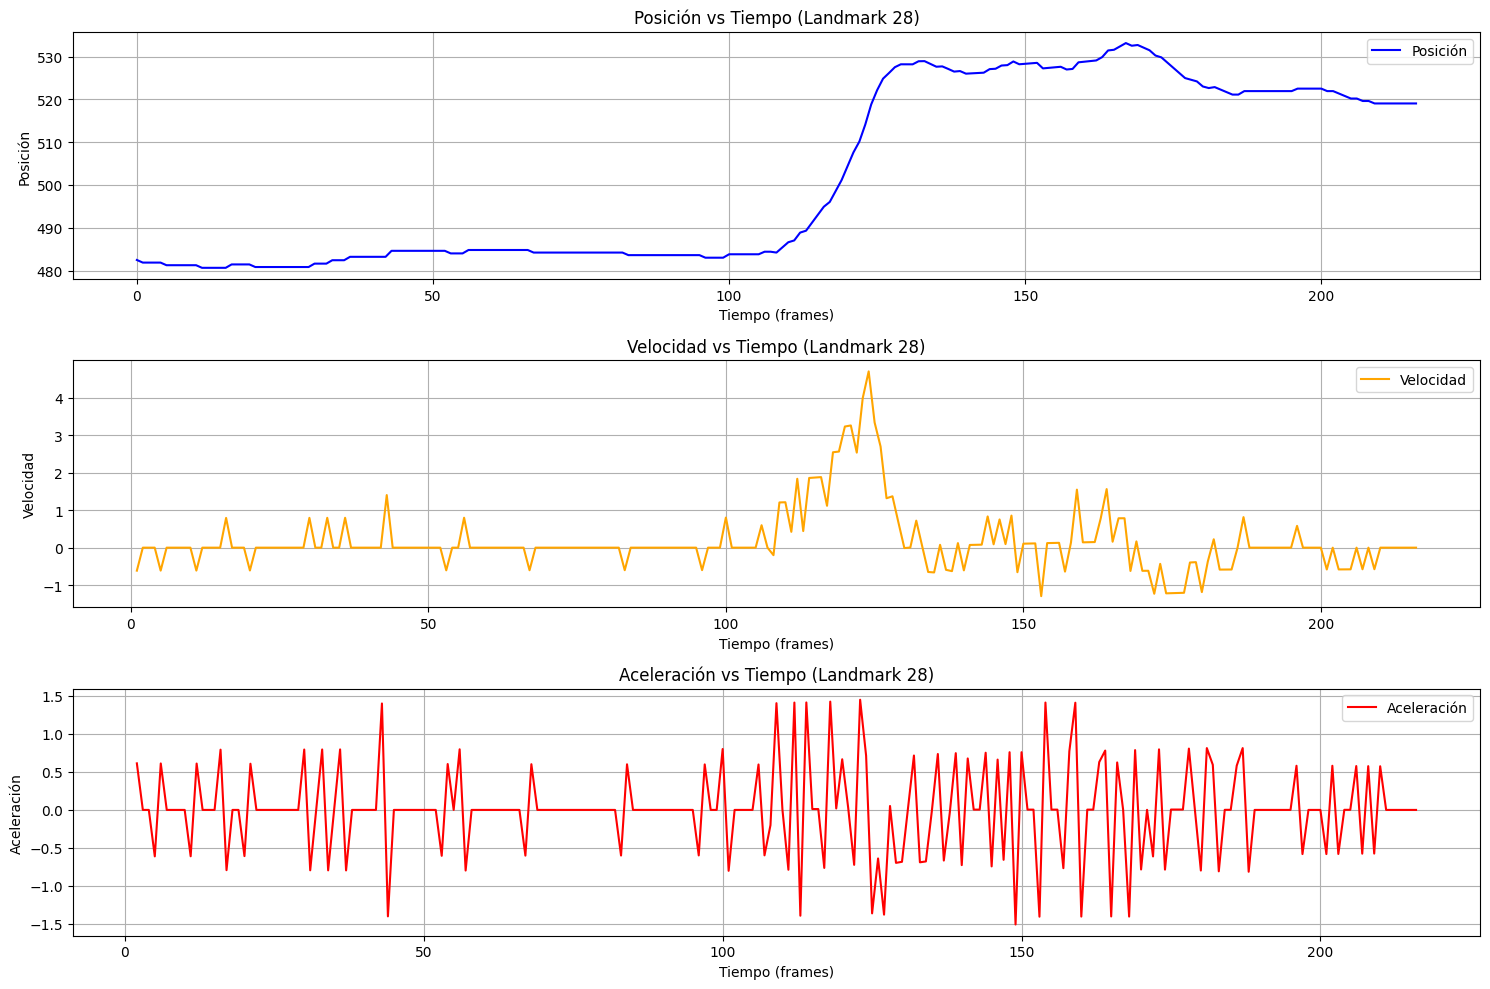

Datos de los landmarks 26 y 28 guardados en: output\trackeo_deseado.csv


In [8]:
import pandas as pd
import numpy as np
import math
import os
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Cargar el CSV original con todos los landmarks trackeados
csv_file_path = 'output/tracked_landmarks.csv'  # Cambia esta ruta si es necesario
df = pd.read_csv(csv_file_path)
landmark_id1 = 26
landmark_id2 = 28

# Filtrar solo las filas donde landmark_id es 26 y 28
df_landmark1 = df[df['landmark_id'] == landmark_id1]
df_landmark2 = df[df['landmark_id'] == landmark_id2]

# Pivotar los datos para que cada fila contenga las coordenadas de ambos landmarks para un mismo frame
df_pivot = df.pivot(index='frame', columns='landmark_id', values=['x', 'y'])

# Renombrar las columnas para mayor claridad
df_pivot.columns = ['x_26', 'x_28', 'y_26', 'y_28']

# Aplicar el filtro gaussiano a las coordenadas x e y de ambos landmarks
df_pivot['x_26'] = gaussian_filter1d(df_pivot['x_26'], sigma=2)
df_pivot['x_28'] = gaussian_filter1d(df_pivot['x_28'], sigma=2)
df_pivot['y_26'] = gaussian_filter1d(df_pivot['y_26'], sigma=2)
df_pivot['y_28'] = gaussian_filter1d(df_pivot['y_28'], sigma=2)

# Calcular la distancia euclidiana entre los landmarks 26 y 28 para cada frame
df_pivot['distance'] = df_pivot.apply(lambda row: math.sqrt((row['x_26'] - row['x_28'])**2 + (row['y_26'] - row['y_28'])**2), axis=1)

# Calcular la distancia promedio de todas las distancias
distancia_promedio = df_pivot['distance'].mean()
df_pivot['distancia_promedio'] = distancia_promedio  # Asignar el promedio a toda la columna

# Resetear el índice para que el DataFrame esté en un formato plano
df_pivot.reset_index(inplace=True)

# ... existing code ...

# Filtrar solo las filas donde landmark_id es 28
df_landmark_28 = df[df['landmark_id'] == 28]

# Pivotar los datos para que cada fila contenga las coordenadas del landmark 28 para un mismo frame
df_pivot_28 = df_landmark_28.pivot(index='frame', columns='landmark_id', values=['x', 'y'])

# Renombrar las columnas para mayor claridad
df_pivot_28.columns = ['x_28', 'y_28']

# Aplicar el filtro gaussiano a las coordenadas x e y del landmark 28
df_pivot_28['x_28'] = gaussian_filter1d(df_pivot_28['x_28'], sigma=2)
df_pivot_28['y_28'] = gaussian_filter1d(df_pivot_28['y_28'], sigma=2)

# Calcular la posición (distancia desde el origen)
df_pivot_28['position'] = np.sqrt(df_pivot_28['x_28']**2 + df_pivot_28['y_28']**2)

# Calcular la velocidad (diferencia de posición entre frames)
df_pivot_28['velocity'] = df_pivot_28['position'].diff()  # Velocidad como cambio en la posición
df_pivot_28['time'] = df_pivot_28.index  # Suponiendo que cada frame representa un tiempo unitario

# Calcular la aceleración (diferencia de velocidad entre frames)
df_pivot_28['acceleration'] = df_pivot_28['velocity'].diff()  # Aceleración como cambio en la velocidad

# Graficar posición, velocidad y aceleración del landmark 28
plt.figure(figsize=(15, 10))

# Gráfico de posición
plt.subplot(3, 1, 1)
plt.plot(df_pivot_28['time'], df_pivot_28['position'], label='Posición', color='blue')
plt.title('Posición vs Tiempo (Landmark 28)')
plt.xlabel('Tiempo (frames)')
plt.ylabel('Posición')
plt.grid()
plt.legend()

# Gráfico de velocidad
plt.subplot(3, 1, 2)
plt.plot(df_pivot_28['time'], df_pivot_28['velocity'], label='Velocidad', color='orange')
plt.title('Velocidad vs Tiempo (Landmark 28)')
plt.xlabel('Tiempo (frames)')
plt.ylabel('Velocidad')
plt.grid()
plt.legend()

# Gráfico de aceleración
plt.subplot(3, 1, 3)
plt.plot(df_pivot_28['time'], df_pivot_28['acceleration'], label='Aceleración', color='red')
plt.title('Aceleración vs Tiempo (Landmark 28)')
plt.xlabel('Tiempo (frames)')
plt.ylabel('Aceleración')
plt.grid()
plt.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

# ... existing code ...

# Guardar el DataFrame resultante en un nuevo archivo CSV
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_file_path_landmark = os.path.join(output_folder, 'trackeo_deseado.csv')
df_pivot.to_csv(csv_file_path_landmark, index=False)

print(f"Datos de los landmarks 26 y 28 guardados en: {csv_file_path_landmark}")

In [13]:
# Cargar el CSV original con todos los landmarks trackeados
csv_file_path = 'output/trackeo_deseado.csv'  # Cambia esta ruta si es necesario
df = pd.read_csv(csv_file_path)
numero = int(input("ingrese valor en centimetros de la pierna"))
print(df.columns)
valor_distancia_promedio = int(df['distancia_promedio'].iloc[0])
convertidor = int(numero/valor_distancia_promedio)
df_landmark1 = df[df['landmark_id'] == landmark_id1*convertidor]
df_landmark2 = df[df['landmark_id'] == landmark_id2*convertidor]


Index(['frame', 'x_26', 'x_28', 'y_26', 'y_28', 'distance',
       'distancia_promedio'],
      dtype='object')


KeyError: 'landmark_id'